<a href="https://colab.research.google.com/github/Romain-MARRION/Portfolio/blob/main/final_porjetct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization,  RandomFlip,RandomRotation,RandomZoom

In [2]:
SEED=42

In [3]:
train_dataset, validation_dataset , test_dataset = tfds.load(
    'ColorectalHistology', 
    shuffle_files=True,
    read_config = tfds.ReadConfig(shuffle_seed=SEED),
    as_supervised=True,
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteDBF02V/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


all the same lenght and values between 0 and 255

In [4]:
for element in train_dataset.take(3):
    print(element)

(<tf.Tensor: shape=(150, 150, 3), dtype=uint8, numpy=
array([[[238, 211, 226],
        [232, 205, 220],
        [233, 210, 230],
        ...,
        [242, 242, 240],
        [242, 241, 239],
        [244, 243, 241]],

       [[225, 213, 223],
        [223, 211, 221],
        [225, 208, 216],
        ...,
        [243, 242, 240],
        [243, 242, 240],
        [244, 243, 241]],

       [[225, 209, 222],
        [228, 212, 225],
        [230, 214, 224],
        ...,
        [243, 242, 240],
        [243, 242, 240],
        [244, 243, 241]],

       ...,

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 2

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
num_classes=8

In [6]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
image_batch, label_batch = next(iter(train_dataset))
image_batch.shape, label_batch.shape


(TensorShape([32, 150, 150, 3]), TensorShape([32]))

In [9]:
data_augmentation = Sequential(
  [
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [10]:
model=Sequential(
    [   
        Convolution2D(128, (3 ,3), input_shape=(150, 150, 3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        BatchNormalization(),
        Convolution2D(64, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Convolution2D(64, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Convolution2D(64, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.4),
        Convolution2D(64, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.4),
        Flatten(),
        Dense(128,activation='relu'),
        Dropout(0.4),
        Dense(128,activation='relu'),
        Dropout(0.4),
        Dense(128,activation='relu'),
        Dense(activation='softmax', units=num_classes)
    ]
)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                      

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [14]:
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [15]:
history =model.fit(train_dataset, epochs=50, validation_data=validation_dataset,callbacks=[model_checkpoint_callback])

Epoch 1/50
94/94 [==============================] - 18s 85ms/step - loss: 1.7695 - accuracy: 0.2973 - val_loss: 1.6473 - val_accuracy: 0.2600
Epoch 2/50
94/94 [==============================] - 6s 66ms/step - loss: 1.3924 - accuracy: 0.3957 - val_loss: 1.0759 - val_accuracy: 0.6290
Epoch 3/50
94/94 [==============================] - 6s 67ms/step - loss: 1.2351 - accuracy: 0.4677 - val_loss: 0.9065 - val_accuracy: 0.6950
Epoch 4/50
94/94 [==============================] - 6s 67ms/step - loss: 1.0672 - accuracy: 0.5533 - val_loss: 0.8161 - val_accuracy: 0.6990
Epoch 5/50
94/94 [==============================] - 6s 67ms/step - loss: 0.9930 - accuracy: 0.5977 - val_loss: 0.8652 - val_accuracy: 0.6370
Epoch 6/50
94/94 [==============================] - 6s 67ms/step - loss: 0.8935 - accuracy: 0.6340 - val_loss: 0.6935 - val_accuracy: 0.7290
Epoch 7/50
94/94 [==============================] - 6s 67ms/step - loss: 0.8381 - accuracy: 0.6773 - val_loss: 0.7642 - val_accuracy: 0.7010
Epoch 8/50
9

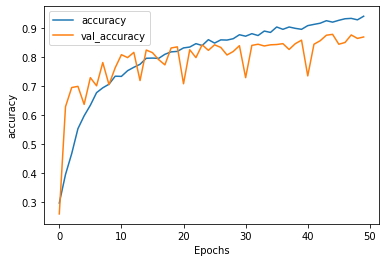

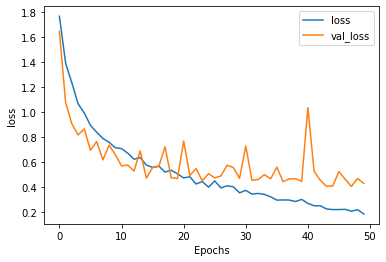

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
model.load_weights('/checkpoint')
model.evaluate(test_dataset)

32/32 [==============================] - 1s 19ms/step - loss: 0.3245 - accuracy: 0.8910


[0.3245295584201813, 0.890999972820282]